## Tools Setup

In [1]:
import pathlib, os, sys, operator, re, datetime
from functools import reduce
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import Model
import tensorflow_datasets as tfds
from tiny_imagenet import TinyImagenetDataset

# Enable or disable GPU
# To fully disable it, we need to hide all GPU devices from Tensorflow
# Make sure GPU is disabled for this inference part of the lab
ENABLE_GPU = True
# tf.debugging.set_log_device_placement(True)

if not ENABLE_GPU:
    tf.config.set_visible_devices([], 'GPU')

# Print Python and TF version, and where we are running
print(f'Running on Python Version: {sys.version}')
print(f'Using Tensorflow Version: {tf. __version__}')
if not tf.config.experimental.list_physical_devices("GPU"):
    print('Running on CPU')
else:
    print(f'Using GPU at: {tf.test.gpu_device_name()} (of {len(tf.config.experimental.list_physical_devices("GPU"))} available)')

2025-09-23 00:03:57.819744: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-23 00:03:57.839669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-23 00:03:57.857802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-23 00:03:57.857824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-23 00:03:57.869371: I tensorflow/core/platform/cpu_feature_gua

Running on Python Version: 3.9.21 (main, Feb 10 2025, 00:00:00) 
[GCC 11.5.0 20240719 (Red Hat 11.5.0-5)]
Using Tensorflow Version: 2.16.2
Using GPU at: /device:GPU:0 (of 1 available)


2025-09-23 00:04:03.127024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-23 00:04:03.153353: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-23 00:04:03.153484: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Dataset Inspection

In [2]:
# This cell imports our dataset.

# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Class Version Source: https://github.com/duweisu/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

tiny_imagenet_builder = TinyImagenetDataset()

# this call (download_and_prepare) will trigger the download of the dataset
# and preparation (conversion to tfrecords)
#
# This will be done only once and on next usage tfds will
# use the cached version on your host.
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# class_names = tiny_imagenet_builder.info.features['label'].names
ds = tiny_imagenet_builder.as_dataset()
ds_train, ds_val = ds["train"], ds["validation"]
assert(isinstance(ds_train, tf.data.Dataset))
assert(isinstance(ds_val, tf.data.Dataset))

# Training Dataset
ds_train = ds_train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
ds_val = ds_val.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Dataset metadata
ds_info = tiny_imagenet_builder.info

2025-09-23 00:04:03.217150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-23 00:04:03.217267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-23 00:04:03.217333: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# We need to read the "human readable" labels so we can translate with the numeric values
# Read the labels file (words.txt)
with open(os.path.abspath('wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.abspath('words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.items():
        wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
        
class_names = [str(wnid_to_words[wnid]) for wnid in wnids]

In [4]:
# Helper function to get the label name
def img_class(img_data, idx=None):
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']
    # Handle batches of images correctly
    if idx != None:
        image, label, id, label_name = img_data["image"][idx], img_data["label"][idx], img_data["id"][idx], img_data["metadata"]['label_name'][idx]
    
    return f"{label_name} (class index: {label} - id: {id})"


# Helper function to show basic info about an image
def img_info(img, idx=None, display=True, title_apend=""):
    image = img['image']

    # Print the class
    class_str = img_class(img, idx)
    print(f"Label: {class_str}")
    
    # Display the image
    if display:
        plt.figure()
        plt.title(title_apend + class_str)
        # Handle batches correctly
        if image.shape.ndims > 3:
            plt.imshow(image.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(image.numpy())

--- Train & Validation dataset info ---
Train: <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'metadata': {'label_name': TensorSpec(shape=(), dtype=tf.string, name=None)}}>
Validation: <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'metadata': {'label_name': TensorSpec(shape=(), dtype=tf.string, name=None)}}>

--- Show an example image ---
Label: b'ice cream, icecream' (class index: 28 - id: b'n07614500')

 Show some other examples


2025-09-23 00:04:03.505785: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-09-23 00:04:03.525011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-23 00:04:03.606156: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

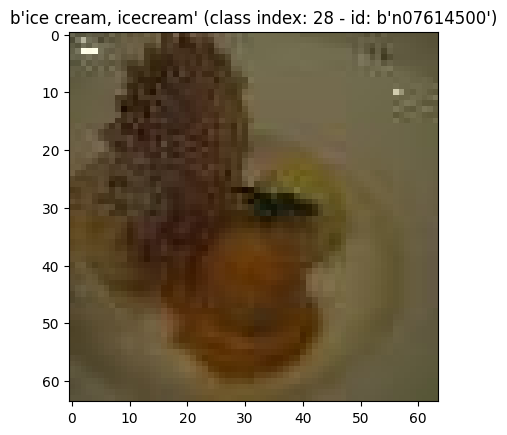

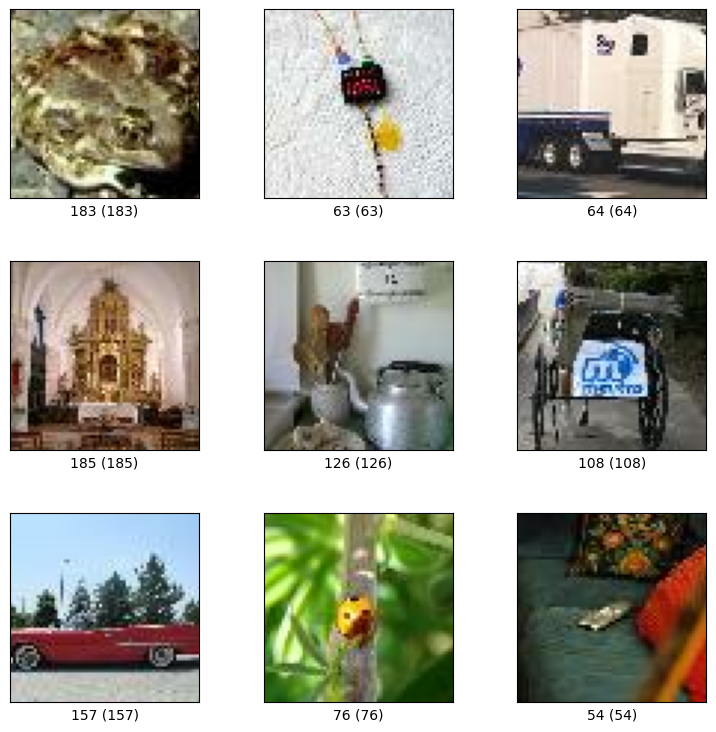

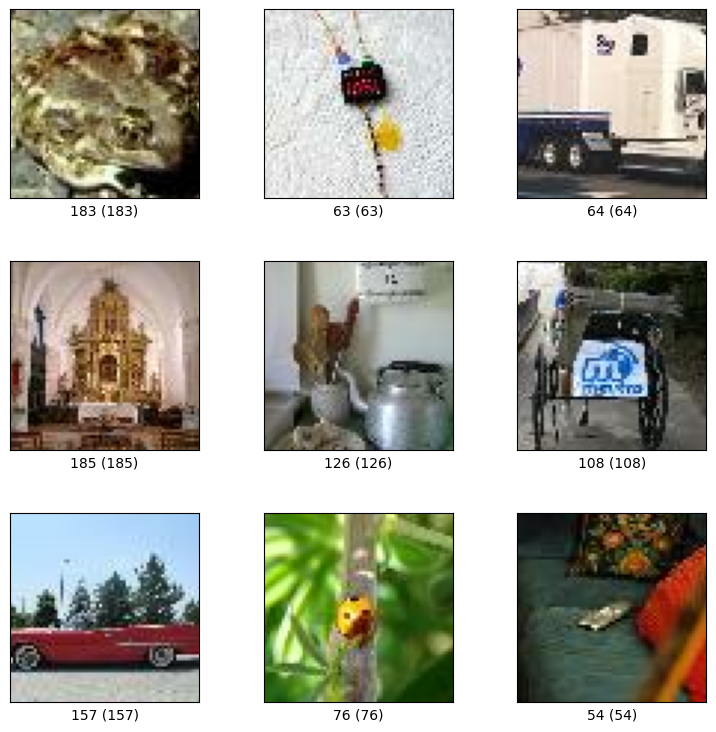

In [5]:
# Print the dataset types and info
print("--- Train & Validation dataset info ---")
print(f"Train: {ds_train}")
print(f"Validation: {ds_val}")
# print(f"Dataset Info: {ds_info}") # Uncomment to print Dataset info

print("\n--- Show an example image ---")
for example in ds_val.take(1):
    img_info(example)

print("\n Show some other examples")
tfds.show_examples(ds_val, ds_info, rows=3, cols=3)


--- Image 0 ---
Label: b'comic book' (class index: 173 - id: b'n06596364')
Data Type - <dtype: 'uint8'>
Dimensions - (64, 64, 3)
uint8 = 1 byte
64 x 64 x 3 * 1 byte = 12228 bytes

--- Image 1 ---
Label: b'abacus' (class index: 63 - id: b'n02666196')
Data Type - <dtype: 'uint8'>
Dimensions - (64, 64, 3)
uint8 = 1 byte
64 x 64 x 3 * 1 byte = 12228 bytes

--- Image 2 ---
Label: b'baboon' (class index: 32 - id: b'n02486410')
Data Type - <dtype: 'uint8'>
Dimensions - (64, 64, 3)
uint8 = 1 byte
64 x 64 x 3 * 1 byte = 12228 bytes


2025-09-23 00:04:04.446867: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-09-23 00:04:04.454560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


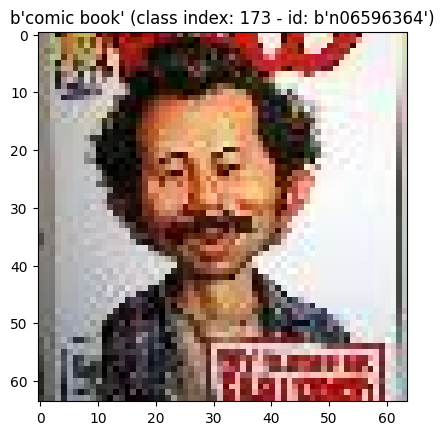

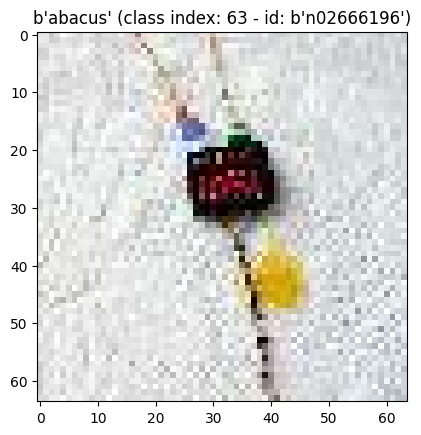

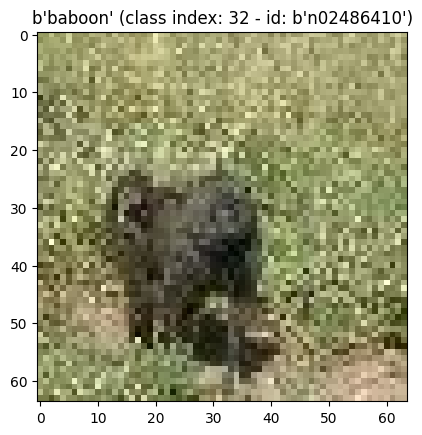

In [6]:
# TODO: Print and visualize three inputs from the validation set
#     : Print the stroage data type
#     : Print and note the dimensions of each image
#     : Print the memory required to store each image

# Sample Images
sample_imgs = []
for index, img_data in enumerate(ds_val.take(3)):
    sample_imgs.append(img_data)
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']

    print(f'\n--- Image {index} ---')
    # TODO: Your Code Here
    img_info(img_data)
    print(f"Data Type - {image.dtype}")
    print(f"Dimensions - {image.shape}")
    print("uint8 = 1 byte\n64 x 64 x 3 * 1 byte = 12228 bytes")
    # See example usage: https://github.com/duweisu/tiny-imagenet-tfds

In [7]:
# TODO: Export each of the three inputs to a binary file which will be used to load the images into C++ later
# NOTE: First flatten the array (ex: 4D --> 1D). So 64*64*3 = 12288 element 1D array

# Make a directory for our image data
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

# Create a metadata file
metadata_file = open(os.path.join(img_dir, f'metadata.txt'), 'w')
metadata_file.write(f'Number\t\tDims\t\tClass Data\n')

# Export each image
for index, img_data in enumerate(sample_imgs):    
    img_file = open(os.path.join(img_dir, f'image_{index}.bin'), 'wb')
    
    # TODO: Your Code Here
    arr = img_data["image"].numpy()
    label = img_data["label"].numpy()
    flat_arr = arr.flatten()
    img_file.write(flat_arr.tobytes())
    img_file.close()
    metadata_file.write(f"{index}\t\t{image.shape}\t\t{label}\n")


## Model Loading and Inference

In [8]:
# TODO: Load the model
# Now we will load the H5 model! Please make sure the h5 model file is present in the below directory.
# You can download this from the Canvas Page and place it in the same directory as this notebook.

# model_path = os.path.abspath(""/home/<NETID>/path/to/your/lab1/CNN_TinyImageNet.h5)" # Uncomment this to use a non-relative path
model_path = os.path.abspath("CNN_TinyImageNet.h5")

# TODO: Your Code Here
model = tf.keras.models.load_model(model_path)
model.summary()

/home/buenting/cpre_5870/lab1/Lab1/lab1_venv/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/buenting/cpre_5870/lab1/Lab1/lab1_venv/lib64/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,218 (2.94 MB)

 Trainable params: 770,216 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

2025-09-23 00:04:05.406201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
I0000 00:00:1758603845.531787 3204543 service.cc:145] XLA service 0x7f03dc0194e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758603845.531820 3204543 service.cc:153]   StreamExecutor device (0): NVIDIA A40-8Q, Compute Capability 8.6
2025-09-23 00:04:05.537929: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-23 00:04:05.581293: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuD

Label: [b'moving van'] (class index: [64] - id: [b'n03796401'])
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
Best Guess [class index]: ['moving van'] [64]
Best Guess Confidence (percent / 1.0): [0.88710463]
Top 15 Guesses (class index): ["['moving van'] [64]", "['cash machine', 'cash dispenser', 'automated teller machine', 'automatic teller machine', 'automated teller', 'automatic teller', 'ATM'] [106]", "['police van', 'police wagon', 'paddy wagon', 'patrol wagon', 'wagon', 'black Maria'] [90]", "['beach wagon', 'station wagon', 'wagon', 'estate car', 'beach waggon', 'station waggon', 'waggon'] [147]", "['CD player'] [70]", "['parking meter'] [10]", "['barrel', 'cask'] [65]", "['refrigerator', 'icebox'] [132]", "['sewing machine'] [129]", "['beacon', 'lighthouse', 'beacon light', 'pharos'] [93]", "['bannister', 'banister', 'balustrade', 'balusters', 'handrail'] [189]", "['trolleybus', 'trolley coach', 'trackless trolley'] [152]", "['limousine', 'limo'] [114]", "['scoreboard'] [148]", "['pay

I0000 00:00:1758603845.984615 3204543 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-09-23 00:04:06.013826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


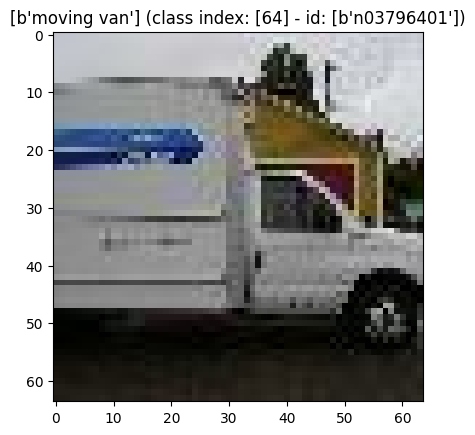

In [9]:
# Running infrence on our model
# We can run an infrence of our model by doing the following (we are doing batches of 1 here)
for example in ds_train.batch(1).take(1):
    img_info(example)
    # Make a prediction
    pred = model.predict(tf.cast(example["image"], tf.float32)/255.0)
    # print(f'Raw 200 Class Weighted Prediction:\n{pred}') # Uncomment to see the raw prediction
    
    # What is out best guess?
    best_guess = tf.math.argmax(pred, axis=1).numpy() # Our output is 200 weighted value, we want the most likely
    print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
    print(f'Best Guess Confidence (percent / 1.0): {pred[0][best_guess]}')

    # What are our top 15 guesses?
    top_15 = tf.math.top_k(pred, k=15)
    print(f'Top 15 Guesses (class index): {[f"{class_names[idx]} [{idx}]" for idx in top_15.indices[0]]}')
    print(f'Top 15 Guesses Confidence (percent / 1.0): {top_15.values}')

In [10]:
# TODO: Run infrence for our previous 3 sample images

# TODO: Your Code Here

# for index, img_data in enumerate(sample_imgs):
    
#     pred = model.predict(tf.cast(img_data["image"], tf.float32)/255.0)
#     sample_predictions.append(pred)
#     best_guess = tf.math.argmax(sample_predictions[index], axis=1).numpy()
#     label = sample_predictions[index]["label"].numpy()
#     print(f"{best_guess}\t\t{pred[0][best_guess]}\t\t")

# Stack all 3 sample images into a stack for the prediction model (3, 64, 64, 3)
imgs = tf.stack([tf.cast(d["image"], tf.float32) / 255.0 for d in sample_imgs], axis = 0)

preds = model.predict(imgs)

print(f"Best guess\t\tAssoc. Conf.\t\tActual Class\n")
for i, pred in enumerate(preds):
    best_guess = np.argmax(pred)
    confidence = pred[best_guess]
    label = sample_imgs[i]["label"].numpy()

    print(f"{best_guess}\t\t{confidence}\t\t{label}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
Best guess		Assoc. Conf.		Actual Class

81		0.2064041942358017		173
76		0.7427392601966858		63
32		0.14564958214759827		32


In [11]:
# # TODO: Calculate the Top-1, Top-5, and Top-10 Accuracy of the validation dataset
total = acc_top1 = acc_top5 = acc_top10 = 0
total = ds_val.cardinality().numpy()
# # TODO: Your Code Here
for images in ds_val.batch(32):
    # Predict the classes for each image, in a batch of 32 images at a time
    preds = model.predict(tf.cast(images["image"], tf.float32)/255.0, verbose = 0)
    labels = images["label"].numpy()

    for i, pred in enumerate(preds):
        top_1 = np.argmax(pred)
        if top_1 == labels[i]:
            acc_top1 += 1

        # top_5 = tf.math.top_k(pred, n=5)
        # for j in range(5):
        #     if top_5[j] == labels[i]:
        #         acc_top5 += 1
        #         break

        # top_10 = tf.math.top_k(pred, n=10)
        # for j in range(10):
        #     if top_10[j] == labels[i]:
        #         acc_top10 += 1
        #         break

        top_5 = tf.math.top_k(pred, k=5).indices.numpy()
        if labels[i] in top_5:
            acc_top5 += 1

        top_10 = tf.math.top_k(pred, k=10).indices.numpy()
        if labels[i] in top_10:
            acc_top10 += 1

print(f"Top 1 Accuracy: {acc_top1/total}\n")
print(f"Top 5 Accuracy: {acc_top5/total}\n")
print(f"Top 10 Accuracy: {acc_top10/total}\n")

I0000 00:00:1758603867.132694 3211274 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 16 bytes spill stores, 16 bytes spill loads



Top 1 Accuracy: 0.2427

Top 5 Accuracy: 0.4941

Top 10 Accuracy: 0.6174



2025-09-23 00:04:27.613128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# # TODO: Print all of the possible classes of the dataset

# # TODO: Your Code Here
train_labels = set()
for batch in ds_train.batch(32):
    train_labels.update(batch["label"].numpy().tolist())

val_labels = set()
for batch in ds_train.batch(32):
    val_labels.update(batch["label"].numpy().tolist())

print("Training classes:", len(train_labels))
print("Validation classes:", len(val_labels))

for i in range(200):
    print({class_names[i],})

2025-09-23 00:04:29.696022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training classes: 200
Validation classes: 200
{"['Egyptian cat']"}
{"['reel']"}
{"['volleyball']"}
{"['rocking chair', 'rocker']"}
{"['lemon']"}
{"['bullfrog', 'Rana catesbeiana']"}
{"['basketball']"}
{"['cliff', 'drop', 'drop-off']"}
{"['espresso']"}
{'[\'plunger\', "plumber\'s helper"]'}
{"['parking meter']"}
{"['German shepherd', 'German shepherd dog', 'German police dog', 'alsatian']"}
{"['dining table', 'board']"}
{"['monarch', 'monarch butterfly', 'milkweed butterfly', 'Danaus plexippus']"}
{"['brown bear', 'bruin', 'Ursus arctos']"}
{"['school bus']"}
{"['pizza', 'pizza pie']"}
{"['guinea pig', 'Cavia cobaya']"}
{"['umbrella']"}
{"['organ', 'pipe organ']"}
{"['oboe', 'hautboy', 'hautbois']"}
{"['maypole']"}
{"['goldfish', 'Carassius auratus']"}
{"['potpie']"}
{"['hourglass']"}
{"['seashore', 'coast', 'seacoast', 'sea-coast']"}
{"['computer keyboard', 'keypad']"}
{"['Arabian camel', 'dromedary', 'Camelus dromedarius']"}
{"['ice cream', 'icecream']"}
{"['nail']"}
{"['space heater'

2025-09-23 00:04:30.247339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model Exploration

In [13]:
# TODO: Visualize the model in Netron (https://netron.app/) and include an image here.
# tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=True, expand_nested=True) # Uncomment this to generate a simple visualization


Layer: conv2d (Conv2D)
Weights shape: (5, 5, 3, 32), Bias shape: (32,)
dtype: float32
Params: 2,432
Memory: 9728 bytes

Layer: conv2d_4 (Conv2D)
Weights shape: (3, 3, 64, 64), Bias shape: (64,)
dtype: float32
Params: 36,928
Memory: 147712 bytes


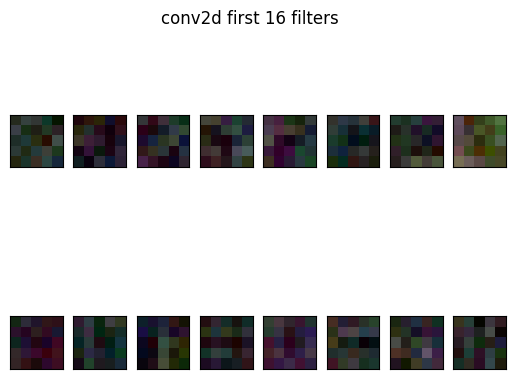

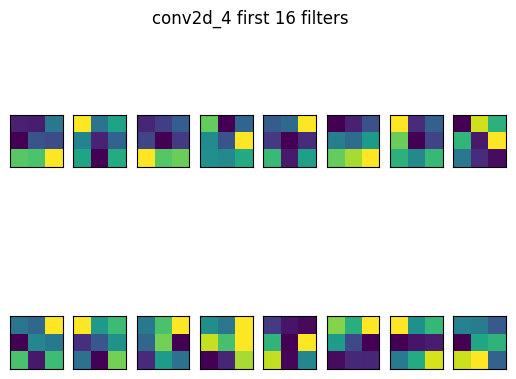

In [14]:
# We can view the layer weights. Here we consider them as images of feature filters applied to intermediate feature map images.
# TODO: Visualize the 2 convolutional layers filter sets (weights) (one at the beginning and one at the end)

# TODO: Your Code Here
conv_layers = [l for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)]
first_conv = conv_layers[0]
last_conv = conv_layers[-2]

def describe_layer(layer):
    W, b = layer.get_weights()
    n_params = W.size + b.size
    mem_bytes = W.nbytes + b.nbytes
    print(f"\nLayer: {layer.name} ({layer.__class__.__name__})")
    print(f"Weights shape: {W.shape}, Bias shape: {b.shape}")
    print(f"dtype: {W.dtype}")
    print(f"Params: {n_params:,}")
    print(f"Memory: {mem_bytes} bytes")
    return W,b

W1, b1 = describe_layer(first_conv)
W2, b2 = describe_layer(last_conv)

def normalize(x):
    x = x - x.min()
    m = x.min()
    return x / (m if m != 0 else 1.0)

num_show1 = min(16, W1.shape[-1])
cols = 8
rows = int(num_show1 / cols)
plt.figure()
for i in range(num_show1):
    f = W1[:, :, :, i]
    f_img = normalize(f)
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(f_img)
    ax.set_xticks([]); ax.set_yticks([])
plt.suptitle(f"{first_conv.name} first {num_show1} filters")
plt.show()

num_show2 = min(16, W2.shape[-1])
rows = int(num_show2 / cols)
plt.figure()
for i in range(num_show2):
    k = W2[:, :, :, i]
    energy = np.sqrt((k**2).sum(axis=2))
    e_img = normalize(energy)
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(e_img)
    ax.set_xticks([]); ax.set_yticks([])
plt.suptitle(f"{last_conv.name} first {num_show2} filters")
plt.show()

Layer name: conv2d 
feature map shape = (1, 60, 60, 32)
dtypefloat32
Data size: 460800


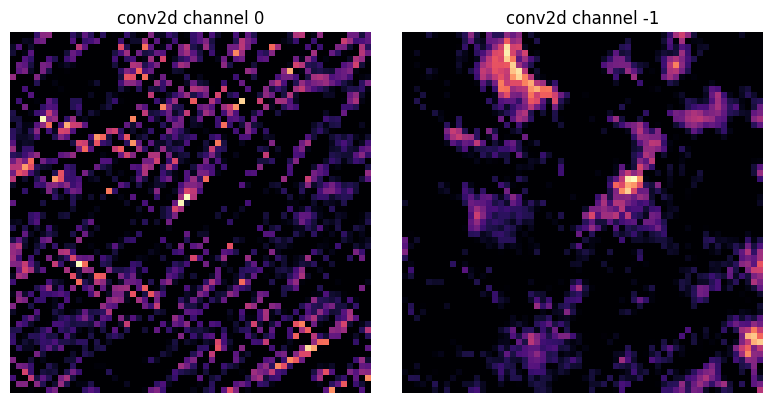

Layer name: conv2d_4 
feature map shape = (1, 10, 10, 64)
dtypefloat32
Data size: 25600


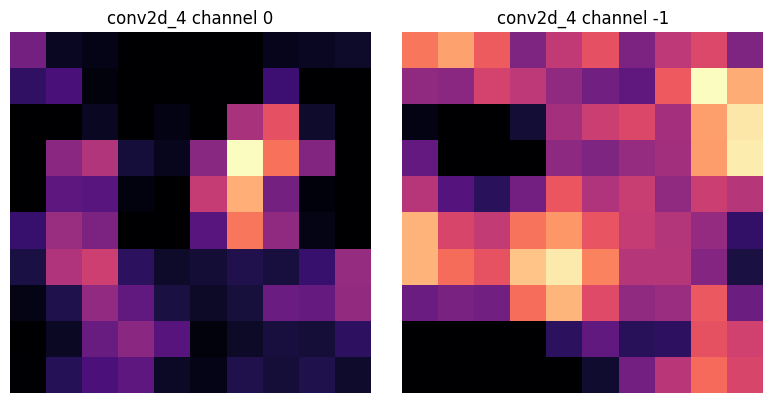

In [15]:
# We can view the layer outputs as well. Here we consider them as images of the spatial location of features.
# TODO: Visualize the 2 convolutional layers outputs (intermediate feature maps) (one at the beginning and one at the end)

# TODO: Your Code Here

example = next(iter(ds_val.batch(1)))
x = tf.cast(example["image"], tf.float32) /  255.0

acts = {}
t = x
for layer in model.layers:
    try:
        t = layer(t, training = False)
    except TypeError:
        t = layer(t)
    if layer is first_conv:
        acts["first"] = t.numpy()
    if layer is last_conv:
        acts["last"] = t.numpy()

feat_first = acts["first"]
feat_last = acts["last"]

def show_feature_maps(F, layer_name, channels=(0, -1), cmap = "magma"):
    F0 = np.asarray(F)[0]
    H, W, C = F0.shape
    print(f"Layer name: {layer_name} ")
    print(f"feature map shape = {(1, H, W, C)}")
    print(f"dtype{F.dtype}")
    print(f"Data size: {F.nbytes}")
    plt.figure(figsize=(4*len(channels), 4))
    for i, ch in enumerate(channels):
        fm = F0[..., ch]
        fm = (fm - fm.min()) / (fm.max() - fm.min() + 1e-8)
        ax = plt.subplot(1, len(channels), i+1)
        ax.imshow(fm, cmap=cmap)
        ax.set_title(f"{layer_name} channel {ch}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_feature_maps(feat_first, first_conv.name)
show_feature_maps(feat_last, last_conv.name)


In [16]:
# TODO: Export the filters/weights se we can use them later
# Make a directory for our image data
model_dir = os.path.abspath('model_data')
pathlib.Path(model_dir).mkdir(exist_ok=True)


# Export each image
conv_index = dense_index = 1 # layer index starts from one
for layer_idx, layer in enumerate(model.layers):
    if re.match(r'(conv|dense)', layer.name):
        weight_file_name = os.path.join(model_dir, f'{layer.name}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'{layer.name}_bias.bin')
    else: continue

    assert layer.weights[0].name.endswith('kernel')
    assert layer.weights[1].name.endswith('bias')
        
    # TODO: Your Code Here
    W, b = layer.get_weights()

    with open(weight_file_name, "wb") as wf:
        wf.write(W.tobytes())

    with open(bias_file_name, "wb") as bf:
        bf.write(b.tobytes())

In [17]:
# TODO: Export the intermediate layer outputs for each of the input for all of the layers
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

for img_idx, img in enumerate(sample_imgs):
    file_dir = os.path.join(img_dir, f'test_input_{img_idx}')
    pathlib.Path(file_dir).mkdir(exist_ok=True)
    
    # TODO: Your Code Here
    x = tf.cast(img["image"], tf.float32)[None, ...] / 255.0
    t = x
    for layer in model.layers:
        try: 
            t = layer(t, training = False)
        except TypeError:
            t = layer(t)
        
        arr = t.numpy()
        out_path = os.path.join(file_dir, f"{layer.name}.bin")
        with open(out_path, "wb") as f:
            f.write(arr.tobytes())

## Tensorboard

In [18]:
tf.config.optimizer.set_jit(False)
tf.config.run_functions_eagerly(False)

# Setup for profiling
opts = tf.profiler.experimental.ProfilerOptions(
    host_tracer_level=2, python_tracer_level=0, device_tracer_level=1
)

log_dir = os.path.abspath(os.path.join('log_data'))
log_dir_run = os.path.abspath(os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(log_dir_run).mkdir(exist_ok=True, parents=True)

try:
    tf.profiler.experimental.stop()
except:
    test = 2
finally:
    test = 1

In [19]:
# TODO: Sample Profiling - Inference for a single image:

import time


# tf.profiler.experimental.start(log_dir_run)

latency = []

@tf.function(jit_compile=False)
def run_infer(x):
    return model(x, training = False)

_ = run_infer(tf.zeros((1,64,64,3), tf.float32))

# Perform the inference profiling:
for i, image in enumerate(sample_imgs):
    # Starts Profile logging
    sub_dir = os.path.join(log_dir_run, f'img_{i}')
    x = tf.cast(image["image"], tf.float32)
    x = tf.expand_dims(x, axis = 0) / 255.0
    tf.profiler.experimental.start(sub_dir, options=opts)
    try:
        tf.profiler.experimental.Trace("single_inference", step_num = 0, _r = 1)
        t0 = time.perf_counter()
        pred = run_infer(x)
        _ = pred.numpy()
        t1 = time.perf_counter()
        latency.append((t1-t0) * 1e3)
    finally:
        tf.profiler.experimental.stop()
        print(f'Latency for Image {i}: {latency[i]}')
    
    file_writer = tf.summary.create_file_writer(sub_dir)
    with file_writer.as_default():
        tf.summary.scalar("latency_ms", latency[i], step=0)
    file_writer.flush()


    

2025-09-23 00:04:31.505761: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-09-23 00:04:31.505789: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-09-23 00:04:31.505805: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1239] Profiler found 1 GPUs
2025-09-23 00:04:31.506006: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:137] cuptiGetTimestamp: error 999: 
2025-09-23 00:04:31.506014: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2025-09-23 00:04:31.506017: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-09-23 00:04:31.506021: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with

Latency for Image 0: 1.0397867299616337
Latency for Image 1: 1.4343131333589554
Latency for Image 2: 1.1502769775688648


2025-09-23 00:04:31.858453: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-09-23 00:04:31.858483: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-09-23 00:04:31.858497: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-09-23 00:04:31.858501: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2025-09-23 00:04:31.858505: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-09-23 00:04:31.858508: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2025-09-23 00:04:31.860046: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] 

In [20]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile. 
# *** Please note just execute this command once in a session and 
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
print(log_dir_run)
%tensorboard --logdir={log_dir_run} --port=6006

# You can view the tensorboard in the browser url: http://localhost:6006/

# Useful command line to have if tensorboard is misbehaving: kill $(ps -e | grep 'tensorboard' | awk '{print $1}')

/home/buenting/cpre_5870/lab1/Lab1/log_data/20250923-000431


In [21]:
# TODO: Sample Profiling - Online Inference:

# Vary this from 10, 100, 1000 to simulate multiple online inference
loop_index = [10, 100, 1000]

for idx in loop_index:
    sub_dir = os.path.join(log_dir_run, f'loop_{idx}')
    tf.profiler.experimental.start(sub_dir, options=opts)
    for img in ds_val.batch(1).take(idx):
        x = tf.cast(img['image'], tf.float32)/255.0
        tf.profiler.experimental.Trace("Multiple Online Inference Profiling", step_num = 0, _r = 1)
        pred = run_infer(x)
        _ = pred.numpy()
    tf.profiler.experimental.stop()
    print(f'latency test for set {idx} done')
    file_writer = tf.summary.create_file_writer(sub_dir)
    with file_writer.as_default():
        tf.summary.scalar("latency_ms", latency[i], step=0)
    file_writer.flush()


2025-09-23 00:04:35.477176: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-09-23 00:04:35.477208: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-09-23 00:04:35.477240: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-09-23 00:04:35.477248: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2025-09-23 00:04:35.477251: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-09-23 00:04:35.477255: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2025-09-23 00:04:35.515918: W tensorflow/core/framework/local_rendezvous.cc:404] Local ren

latency test for set 10 done


2025-09-23 00:04:35.701766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-23 00:04:35.702591: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-09-23 00:04:35.704193: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-09-23 00:04:35.704217: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-09-23 00:04:35.704221: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2025-09-23 00:04:35.735598: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-09-23 00:04:35.735620: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cup

latency test for set 100 done


2025-09-23 00:04:37.132162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-23 00:04:37.132941: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-09-23 00:04:37.136017: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-09-23 00:04:37.136035: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-09-23 00:04:37.136039: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2025-09-23 00:04:37.387003: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-09-23 00:04:37.387036: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cup

latency test for set 1000 done


In [22]:
# TODO: Sample Profiling - Batch Inference:

# We would only perform batch inference for a subset of validation set i.e. 1000 images 
# using different batch sizes of 20, 40, 100, 200 

# Decides the size of the batch. Try: 20, 40, 100, 200
batch_size = [20, 40, 100, 200]

for batch in batch_size:
    sub_dir = os.path.join(log_dir_run, f'batch_{batch}')
    tf.profiler.experimental.start(sub_dir, options=opts)
    for imgs in ds_val.take(1000).batch(batch):
        imgs_stzd = tf.cast(imgs['image'], tf.float32)/255.0
        tf.profiler.experimental.Trace("Batch Inference Profiling", step_num = 0, _r = 1)
        pred = run_infer(imgs_stzd)
        _ = pred.numpy()
    tf.profiler.experimental.stop()
    print(f'latency test for batch {batch} done')

    file_writer = tf.summary.create_file_writer(sub_dir)
    with file_writer.as_default():
        tf.summary.scalar("latency_ms", latency[i], step=0)
    file_writer.flush()
        

2025-09-23 00:04:37.673499: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-09-23 00:04:37.673523: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-09-23 00:04:37.673539: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-09-23 00:04:37.673545: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2025-09-23 00:04:37.673548: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-09-23 00:04:37.673552: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2025-09-23 00:04:37.916731: W tensorflow/core/framework/local_rendezvous.cc:404] Local ren

latency test for batch 20 done


2025-09-23 00:04:38.409001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-23 00:04:38.409805: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-09-23 00:04:38.412354: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-09-23 00:04:38.412373: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-09-23 00:04:38.412377: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2025-09-23 00:04:38.440298: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-09-23 00:04:38.440321: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cup

latency test for batch 40 done


2025-09-23 00:04:38.709626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-23 00:04:38.710413: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-09-23 00:04:38.712593: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-09-23 00:04:38.712613: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-09-23 00:04:38.712617: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2025-09-23 00:04:38.736659: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-09-23 00:04:38.736683: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cup

latency test for batch 100 done
latency test for batch 200 done


2025-09-23 00:04:39.049697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-23 00:04:39.050478: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-09-23 00:04:39.052415: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-09-23 00:04:39.052434: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-09-23 00:04:39.052439: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2025-09-23 00:04:39.074282: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-09-23 00:04:39.074303: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cup

## Training

In [23]:
# Setup for model training
from tensorflow.keras import Model, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D,Convolution2D, Activation, Dropout 

train_dir = os.path.abspath(os.path.join('train_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(train_dir).mkdir(exist_ok=True, parents=True)

# Using early stopping to monitor validation accuracy
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(log_dir=train_dir, histogram_freq=1)
]

In [24]:
# Basic CNN model
train_model = Sequential()

# conv1
train_model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3), activation='relu'))
train_model.add(Conv2D(32, (5,5),activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(Conv2D(128, (3,3), activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Flatten())

# fc1
train_model.add(Dense(256, activation='relu'))

# fc2
train_model.add(Dense(200, activation='softmax'))

train_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# TODO: Consider looking at different optimizers and learning rate settings
train_model.summary()

/home/buenting/cpre_5870/lab1/Lab1/lab1_venv/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,216 (2.94 MB)

 Trainable params: 770,216 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# TODO: Attempt to train your own model with different batch sizes
# TODO: See how long this takes without a GPU on your VDI or 2050 Coover machines
# TODO: THEN log in to your GPU VM, set ENABLE_GPU = False in the very first cell, and re-run all above cells
# TODO: Make sure you have exported the LD_LIBRARY_PATH as the lab manual indicates

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def to_categorical(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 200, dtype = tf.float32)
    return tf.cast(image, tf.float32), label

ds_re = tiny_imagenet_builder.as_dataset(as_supervised=True)
ds_retrain, ds_reval = ds_re["train"], ds_re["validation"]

ds_retrain = (ds_retrain
              .shuffle(1024)
              .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
              .map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)
              .cache())

ds_reval = (ds_reval
              .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
              .map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)
              .cache())

check_ds = (ds_retrain
            .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
            .map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE))

xb, yb = next(iter(check_ds.batch(64).take(1)))  # OK because this pipeline has no cache
print('x mean/std:', float(tf.reduce_mean(xb)), float(tf.math.reduce_std(xb)))
print('y dtype/shape:', yb.dtype, yb.shape)
print('class id range (argmax):',
      int(tf.reduce_min(tf.argmax(yb,1))), int(tf.reduce_max(tf.argmax(yb,1))))

epoch_size = 20

init_weights = train_model.get_weights()

for batch_size in [32, 64, 128]:
    # Setup our batched datasets
    ds_retrain_batches = ds_retrain.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    ds_reval_batches = ds_reval.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    train_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )

    train_model.fit(
        ds_retrain_batches, 
        epochs = epoch_size, 
        validation_data = ds_reval_batches,
        callbacks = callbacks
    )
    
    train_model.save(os.path.join(train_dir, f'CNN_Train_Batch_Size_{batch_size}.h5'))

    total = ds_reval.cardinality().numpy()

    for images, labels in ds_reval.batch(batch_size):
        preds = train_model.predict(images, verbose = 0)
        labels_ids = np.argmax(labels.numpy(), axis = 1)

        for i, pred in enumerate(preds):
            top_1 = np.argmax(pred)
            if top_1 == labels_ids[i]:
                acc_top1 += 1
            
            top_5 = tf.math.top_k(pred, k=5).indices.numpy()
            if labels_ids[i] in top_5:
                acc_top5 += 1

    print(f"Top 1 Accuracy: {acc_top1/total}\n")
    print(f"Top 5 Accuracy: {acc_top5/total}\n")

    train_model.set_weights(init_weights)

x mean/std: 0.0018701954977586865 0.001127427676692605
y dtype/shape: <dtype: 'float32'> (64, 200, 200)
class id range (argmax): 0 198
Epoch 1/20


2025-09-23 00:04:39.449384: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-09-23 00:04:39.449500: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - categorical_accuracy: 0.0049 - loss: 5.2991 - val_categorical_accuracy: 0.0050 - val_loss: 5.2984
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - categorical_accuracy: 0.0044 - loss: 5.2992 - val_categorical_accuracy: 0.0050 - val_loss: 5.2984
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - categorical_accuracy: 0.0046 - loss: 5.2994 - val_categorical_accuracy: 0.0050 - val_loss: 5.2984
Epoch 3: early stopping


Top 1 Accuracy: 0.2477

Top 5 Accuracy: 0.5191

Epoch 1/20


2025-09-23 00:05:45.428062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1758603947.344740 3218400 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_721', 88 bytes spill stores, 88 bytes spill loads

I0000 00:00:1758603947.569843 3218398 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_876', 112 bytes spill stores, 112 bytes spill loads

I0000 00:00:1758603947.652526 3218397 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_876', 124 bytes spill stores, 124 bytes spill loads

I0000 00:00:1758603948.637820 3218393 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_721', 312 bytes spill stores, 280 bytes spill loads



1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - categorical_accuracy: 0.0180 - loss: 5.1082 - val_categorical_accuracy: 0.0638 - val_loss: 4.6034
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - categorical_accuracy: 0.0802 - loss: 4.4629 - val_categorical_accuracy: 0.1071 - val_loss: 4.2349
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - categorical_accuracy: 0.1319 - loss: 4.0780 - val_categorical_accuracy: 0.1460 - val_loss: 3.9827
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - categorical_accuracy: 0.1720 - loss: 3.8110 - val_categorical_accuracy: 0.1633 - val_loss: 3.8854
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - categorical_accuracy: 0.2009 - loss: 3.6220 - val_categorical_accuracy: 0.1697 - val_loss: 3.8588
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - categorical_accuracy: 0.2224 - loss: 3.4729 - val_categorical_accuracy: 0.1743 - val_loss: 3.8473
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - categorical_accuracy: 0.

Top 1 Accuracy: 0.4142

Top 5 Accuracy: 0.9066

Epoch 1/20


2025-09-23 00:07:31.649207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1758604054.312229 3222192 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_876', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1758604054.883749 3222192 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_876', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1758604055.193186 3222188 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_721', 252 bytes spill stores, 220 bytes spill loads

I0000 00:00:1758604055.443884 3222187 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_721', 88 bytes spill stores, 88 bytes spill loads



782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - categorical_accuracy: 0.0196 - loss: 5.0939 - val_categorical_accuracy: 0.0640 - val_loss: 4.6282
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - categorical_accuracy: 0.0883 - loss: 4.4054 - val_categorical_accuracy: 0.1287 - val_loss: 4.0786
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - categorical_accuracy: 0.1496 - loss: 3.9388 - val_categorical_accuracy: 0.1622 - val_loss: 3.8397
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - categorical_accuracy: 0.1950 - loss: 3.6554 - val_categorical_accuracy: 0.1826 - val_loss: 3.6949
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - categorical_accuracy: 0.2289 - loss: 3.4533 - val_categorical_accuracy: 0.1990 - val_loss: 3.6520
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - categorical_accuracy: 0.2536 - loss: 3.3018 - val_categorical_accuracy: 0.1989 - val_loss: 3.6549
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - categorical_accuracy: 0.2730 - loss: 

Top 1 Accuracy: 0.6094

Top 5 Accuracy: 1.3479



2025-09-23 00:08:48.878996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
# TODO: Train your model with 3 different numbers of epochs
batch_size = 32

# Setup your datasets
ds_retrain_batches = ds_retrain.batch(batch_size)
ds_reval_batches = ds_reval.batch(batch_size)

for epoch_size in [3, 10, 100]:
    train_model.fit(
        ds_retrain_batches,
        epochs = epoch_size,
        validation_data = ds_reval_batches,
        callbacks = callbacks
    )

    # Save the cnn model
    train_model.save(os.path.join(train_dir, f'CNN_Train_Epoch_Size_{epoch_size}.h5'))

    #Get top 1 and top 5 percentages
    for images, labels in ds_reval.batch(batch_size):
        preds = train_model.predict((tf.cast(images, tf.float32)/255.0), verbose = 0)
        labels_ids = np.argmax(labels.numpy(), axis = 1)

        for i, pred in enumerate(preds):
            top_1 = np.argmax(pred)
            if top_1 == labels_ids[i]:
                acc_top1 += 1
            
            top_5 = tf.math.top_k(pred, k=5).indices.numpy()
            if labels_ids[i] in top_5:
                acc_top5 += 1

    print(f"Top 1 Accuracy: {acc_top1/total}\n")
    print(f"Top 5 Accuracy: {acc_top5/total}\n")
    train_model.set_weights(init_weights)

Epoch 1/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - categorical_accuracy: 0.0049 - loss: 5.2966 - val_categorical_accuracy: 0.0177 - val_loss: 5.0680
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - categorical_accuracy: 0.0305 - loss: 4.9284 - val_categorical_accuracy: 0.0697 - val_loss: 4.5325
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - categorical_accuracy: 0.0852 - loss: 4.4199 - val_categorical_accuracy: 0.1111 - val_loss: 4.2089


Top 1 Accuracy: 0.6144

Top 5 Accuracy: 1.3729

Epoch 1/10
  37/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - categorical_accuracy: 0.0035 - loss: 5.3030

2025-09-23 00:09:50.368941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - categorical_accuracy: 0.0043 - loss: 5.2995 - val_categorical_accuracy: 0.0050 - val_loss: 5.2984
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - categorical_accuracy: 0.0048 - loss: 5.2993 - val_categorical_accuracy: 0.0050 - val_loss: 5.2984
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - categorical_accuracy: 0.0046 - loss: 5.2994 - val_categorical_accuracy: 0.0050 - val_loss: 5.2984
Epoch 3: early stopping


Top 1 Accuracy: 0.6194

Top 5 Accuracy: 1.3979

Epoch 1/100
  37/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - categorical_accuracy: 0.0032 - loss: 5.3110

2025-09-23 00:10:49.987345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - categorical_accuracy: 0.0048 - loss: 5.2995 - val_categorical_accuracy: 0.0050 - val_loss: 5.2984
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - categorical_accuracy: 0.0046 - loss: 5.2993 - val_categorical_accuracy: 0.0050 - val_loss: 5.2984
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - categorical_accuracy: 0.0045 - loss: 5.2994 - val_categorical_accuracy: 0.0050 - val_loss: 5.2984
Epoch 3: early stopping


Top 1 Accuracy: 0.6244

Top 5 Accuracy: 1.4229



2025-09-23 00:11:48.504477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Above and Beyond

In [27]:
# Benchmark our dataset to make sure loading our data isn't a bottleneck ... and because we can
# (This can be skipped since it can take a bit and is't all that important)

# tfds.benchmark(ds_train.batch(32), batch_size=32, num_iter=2**20)

In [28]:
# Explore new models to find a higher-accuracy model. Does the new model require more or less time?